In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import os


# --- Caricamento dataset ---
# get parent dir
parent_dir = os.path.dirname(os.getcwd())

# load the dataset
df = pd.read_csv(os.path.join(
    parent_dir, 'dm2_dataset_2425_imdb',
    'imdb_ts.csv'))



# --- Preprocessing genre ---
df['genre'] = df['genre'].apply(lambda x: x.split(',') if pd.notna(x) else x)
# clean genre column from [, ], '
df['genre'] = df['genre'].apply(
    lambda x: [i.strip().replace("'", "").replace("[", "").replace("]", "") for i in x] if isinstance(x, list) else x
)

# Compute frequency encoding for each genre
from collections import Counter
genre_counts = Counter(genre for sublist in df['genre'].dropna() for genre in sublist)
genre_freq = {genre: count / len(df) for genre, count in genre_counts.items()}

# convert genre column into genre1, genre2, genre3 columns, sorting on frequency
df['genre'] = df['genre'].apply(lambda x: sorted(x, key=lambda y: genre_freq.get(y, 0), reverse=True) if isinstance(x, list) else x)

genre_cols = ['genre1', 'genre2', 'genre3']

df[genre_cols] = pd.DataFrame(df['genre'].tolist(), index=df.index).iloc[:, :3]
df = df.drop(columns=['genre'])

# convert genre columns into frequency encoding
df['genre1'] = df['genre1'].map(genre_freq)
df['genre2'] = df['genre2'].map(genre_freq)
df['genre3'] = df['genre3'].map(genre_freq)

df = df.fillna(0)

#sto aggiungendo qui!
X_genres = df[genre_cols].fillna(0).values

# Merge classi poco rappresentate
df["rating_category"] = df["rating_category"].replace({"Medium Low": "Low"})

# Feature e target
X_ts = df.iloc[:, 1:100].values
y = df["rating_category"].values

# Encoding target
le = LabelEncoder()
y_encoded = le.fit_transform(y)


X_train_ts, X_test_ts, X_train_genre, X_test_genre, y_train, y_test = train_test_split(
    X_ts, X_genres, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Log-transform + Normalizzazione ---
X_train_log = np.log1p(X_train_ts)
X_test_log = np.log1p(X_test_ts)

scaler_ts = TimeSeriesScalerMeanVariance()
X_train_scaled = scaler_ts.fit_transform(X_train_log)
X_test_scaled = scaler_ts.transform(X_test_log)

# Conversione in formato nested per sktime
X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# ==========================
# Shapelet Transform + RandomizedSearchCV su RandomForest
# ==========================
shapelet_transform = RandomShapeletTransform(
    max_shapelets=200,
    min_shapelet_length=7,
    max_shapelet_length=29,
    random_state=42,
    n_jobs=-1
)


shapelet_transform.fit(X_train_nested, y_train)

X_train_shapelets = shapelet_transform.transform(X_train_nested)
X_test_shapelets = shapelet_transform.transform(X_test_nested)

X_train_combined = np.hstack([X_train_shapelets, X_train_genre])
X_test_combined = np.hstack([X_test_shapelets, X_test_genre])

# Scaling finale
scaler_final = StandardScaler()
X_train_final = scaler_final.fit_transform(X_train_combined)
X_test_final = scaler_final.transform(X_test_combined)

#### CLASS WEIGHT BALANCED ####
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,           
    cv=3,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit della RandomizedSearch
random_search.fit(X_train_final, y_train)

print("\n=== RandomizedSearchCV completed ===")
print("Best params:", random_search.best_params_)
print("Best CV balanced accuracy:", random_search.best_score_)

# Valutazione sul test set
y_pred = random_search.predict(X_test_final)

# print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))


import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Desired order
labels = ['Low', 'Medium', 'Medium High', 'High']

# Map your label encoder classes to numeric values according to the desired order
label_order_indices = [np.where(le.classes_ == lbl)[0][0] for lbl in labels]

Fitting 3 folds for each of 20 candidates, totalling 60 fits

=== RandomizedSearchCV completed ===
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
Best CV balanced accuracy: 0.40831415839377255
Balanced Accuracy: 0.38269509476031216
F1 Macro: 0.38321144430844556


              precision    recall  f1-score   support

         Low       0.32      0.25      0.28        28
      Medium       0.45      0.54      0.49        78
 Medium High       0.26      0.20      0.23        46
        High       0.53      0.55      0.54        75

    accuracy                           0.44       227
   macro avg       0.39      0.38      0.38       227
weighted avg       0.42      0.44      0.43       227



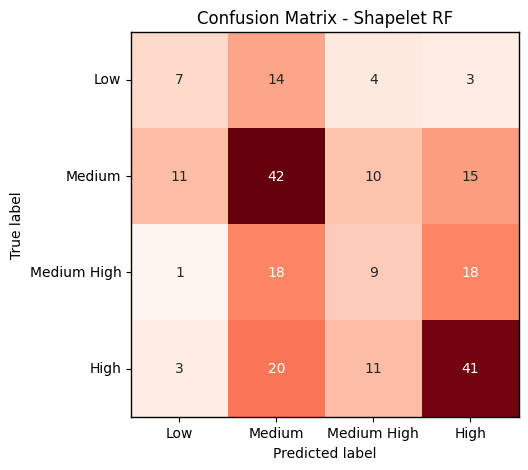

In [2]:
# Classification report with custom label order
print(classification_report(
    y_test, y_pred, labels=label_order_indices, target_names=labels
))

# Confusion matrix with the same label order
cm = confusion_matrix(y_test, y_pred, labels=label_order_indices)

# Plot
plt.figure(figsize=(5, 5))
ax = sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    cmap='Reds', cbar=False
)
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)
plt.title("Confusion Matrix - Shapelet RF")
plt.ylabel(ylabel='True label')
plt.xlabel(xlabel='Predicted label')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
plt.show()

In [3]:
import numpy as np

# 1. Use a standard Python list to collect the class values (index 5)
class_list = []
for shapelet in shapelet_transform.shapelets:
    # Assuming the class value is correctly located at index 5 in the shapelet tuple
    class_list.append(shapelet[5])

# 2. Convert the list to a set to find unique values
unique_classes = set(class_list)

# 3. Print the unique values
print(unique_classes)

{0, 1, 2, 3}


In [4]:
# --- Extraction and Interpretation of Shapelets ---
try:
    all_shapelets = shapelet_transform.shapelets
except AttributeError:
    print("Error: 'shapelets_' attribute not found. Ensure RandomShapeletTransform is fitted.")
    all_shapelets = []

best_rf_model = random_search.best_estimator_

feature_importances = best_rf_model.feature_importances_

n_shapelet_features = X_train_shapelets.shape[1]

# Extract importances only for the shapelet features
shapelet_importances = feature_importances[:n_shapelet_features]

top_k = 30
top_indices = np.argsort(shapelet_importances)[::-1][:top_k]

# print("\n==============================================")
# print(f"Top {top_k} Most Influential Shapelets (by Random Forest Importance)")
# print("==============================================")

for rank, index in enumerate(top_indices):
    importance = shapelet_importances[index]
    try:
        shapelet_object = shapelet_transform.shapelets[index]

        print(f"Rank {rank+1}: Shapelet Feature Index {index}, Importance: {importance:.4f}")
        print(f"  Class: {le.classes_[shapelet_object[5]]}, Gain: {all_shapelets[index][0]}, starting index: {all_shapelets[index][2]}")
        
    except IndexError:
        print(f"Could not retrieve details for Shapelet Index {index}")

Rank 1: Shapelet Feature Index 172, Importance: 0.0140
  Class: Medium High, Gain: 0.013073543734, starting index: 13
Rank 2: Shapelet Feature Index 76, Importance: 0.0133
  Class: Low, Gain: 0.033632400491, starting index: 46
Rank 3: Shapelet Feature Index 80, Importance: 0.0111
  Class: Low, Gain: 0.032562242574, starting index: 17
Rank 4: Shapelet Feature Index 107, Importance: 0.0102
  Class: Low, Gain: 0.028383939043, starting index: 4
Rank 5: Shapelet Feature Index 152, Importance: 0.0096
  Class: Medium High, Gain: 0.017176876799, starting index: 56
Rank 6: Shapelet Feature Index 147, Importance: 0.0095
  Class: Low, Gain: 0.023053779229999998, starting index: 67
Rank 7: Shapelet Feature Index 157, Importance: 0.0092
  Class: Medium High, Gain: 0.015189240765, starting index: 64
Rank 8: Shapelet Feature Index 14, Importance: 0.0085
  Class: High, Gain: 0.08337161989, starting index: 29
Rank 9: Shapelet Feature Index 170, Importance: 0.0084
  Class: Medium High, Gain: 0.013245552

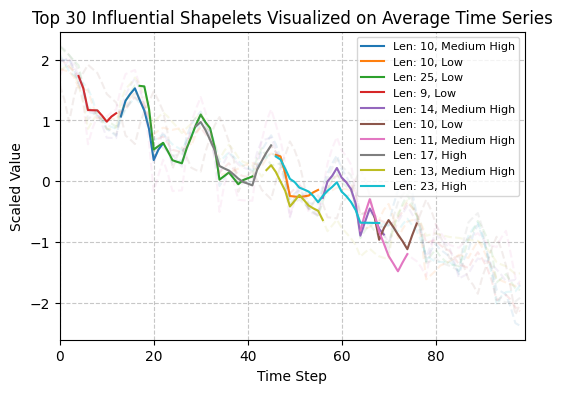

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get the mean time series to use as a background reference
if X_train_scaled.ndim == 3:
    # Handle the original 3D array (Samples, Timesteps, Variables)
    avg_series = X_train_scaled.mean(axis=0).squeeze()
elif X_train_scaled.ndim == 2:
    # Handle the 2D array (Samples, Timesteps) which was used for nesting
    avg_series = X_train_scaled.mean(axis=0)
else:
    print("Warning: X_train_scaled dimension not recognized. Using a single series for context.")
    avg_series = X_train_nested.iloc[0, 0] # Assumes nested is a DataFrame with Series in cell
    

series_length = len(avg_series)

# Map the feature indices (top_indices) to the actual shapelet index (in all_shapelets)
shapelet_indices = [idx // 2 for idx in top_indices]

# --- 3. Plotting ---
plt.figure(figsize=(6, 4))
plt.title(f"Top {top_k} Influential Shapelets Visualized on Average Time Series")

# Plot the average series for context
# plt.plot(avg_series, color='gray', linestyle='--', label='Average Training Series', alpha=0.5)

colors = [
    'tab:blue',
    'tab:orange',
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan'
]

# Plot the top K shapelets
i = 0
for _, index in enumerate(top_indices[:10]):
    try:
        # Index 0: Information Gain / Gini Reduction (The "Influence/Quality")
        gain_or_quality = all_shapelets[index][0]
        # Index 1: The class that is predominantly isolated by this split (The "Preference")
        preferred_class = all_shapelets[index][5]
        preferred_class = le.classes_[preferred_class]
        
        # Extracting positional info
        shapelet_array = all_shapelets[index][6]
        start_pos = all_shapelets[index][2]
        
    except IndexError:
        print(f"Could not extract shapelet data for index {index}. Check tuple structure. Skipping.")
        continue
        
    shapelet_length = len(shapelet_array)
    end_pos = start_pos + shapelet_length
    
    # Create a timeline (X-axis) for the shapelet
    x_values = np.arange(start_pos, end_pos)
    
    
    label_text = (
        # f'Idx: {shapelet_idx}, '
        f'Len: {shapelet_length}, '
        # f'Gain: {gain_or_quality:.4f}, '
        f'{preferred_class}'
    )

    # Plot the shapelet at its learned position
    plt.plot(
        x_values,
        X_train_scaled[index][x_values[0]:x_values[-1] + 1],
        label=label_text,
        color=colors[i],
        linestyle="-",
        linewidth=1.5
    )
    
    # plot original time series
    plt.plot(
        X_train_scaled[index],
        color=colors[i],
        linestyle="--",
        alpha=0.1
    )
    
    i += 1

plt.xlabel("Time Step")
plt.ylabel("Scaled Value")
plt.legend(loc='best', fontsize=8)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, series_length)
plt.show()

In [46]:
import stumpy as st
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Detection of motifs and discords in normalized time series

def plot_matrix_profile(time_series, mp, m, index, n_motifs, rank=None):
    """
    Plots a single time series and its matrix profile, including a legend
    for motifs and discords.

    Args:
        time_series (np.array): The original time series.
        mp (np.array): The computed matrix profile.
        m (int): The subsequence length.
    """
    _, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))
    
    # Plot the original time series
    ax1.plot(time_series, color='tab:grey')
    ax1.set_title(f'Time Series {index}', fontsize=16)
    ax1.set_ylabel('Value', fontsize=12)
    ax1.set_xlabel('Time Step', fontsize=12)
    ax1.grid(alpha=0.5, linestyle='--')
    ax1.set_xlim(0, len(time_series))
    
    # Plot the matrix profile
    ax2.plot(mp, color='tab:grey')
    ax2.set_title('Matrix Profile', fontsize=16)
    ax2.set_xlabel('Subsequence Index', fontsize=12)
    ax2.set_ylabel('Matrix Profile Value', fontsize=12)
    ax2.set_xlim(0, len(time_series))
    
    # Find the top 3 motifs (lowest value) and discords (highest value)
    mp_motif_indeces = np.argsort(mp)[:n_motifs]
    mp_discord_indeces = np.argsort(mp)[-n_motifs:]

    # Plot top 3 motif segments
    for mp_motif_index in mp_motif_indeces:
        # Highlight motif portion
        ax1.axvspan(
            mp_motif_index, mp_motif_index + m,
            facecolor='tab:olive', alpha=0.3
        )
        # Add start and end lines
        ax1.axvline(mp_motif_index, color='tab:olive', linestyle='--', alpha=0.7)
        ax1.axvline(mp_motif_index + m, color='tab:olive', linestyle='--', alpha=0.7)
    
    # Plot discord segment
    for mp_discord_index in mp_discord_indeces:
        ax1.axvspan(
            mp_discord_index, mp_discord_index + m,
            facecolor='tab:cyan', alpha=0.3,
        )
        # Add start and end lines
        ax1.axvline(mp_discord_index, color='tab:cyan', linestyle='--', alpha=0.7)
        ax1.axvline(mp_discord_index + m, color='tab:cyan', linestyle='--', alpha=0.7)
    
    # On matrix profile plot, mark motif/discord points
    for mp_motif_index in mp_motif_indeces:
        ax2.plot(mp_motif_index, mp[mp_motif_index], 'o', color='tab:olive')
    for mp_discord_index in mp_discord_indeces:
        ax2.plot(mp_discord_index, mp[mp_discord_index], 'o', color='tab:cyan')

    # Plot shapelet
    if rank is not None:
        shapelet_array = all_shapelets[index][6]
        start_pos = all_shapelets[index][2]
        end_pos = start_pos + len(shapelet_array)
        indices = np.arange(start_pos, end_pos)
        
        ax1.plot(
            indices,
            time_series[start_pos:end_pos],
            color=colors[rank],
            label='Shapelet'
        )
        
        ax2.plot(start_pos, mp[start_pos], 'o', color=colors[rank], )

    # Add legend to the time series plot
    motif_patch = mpatches.Patch(color='tab:olive', alpha=0.3, label='Motifs')
    discord_patch = mpatches.Patch(color='tab:cyan', alpha=0.3, label='Discords')
    # Add shapelet legend if plotted
    handles = [motif_patch, discord_patch]
    if rank is not None:
        # Correctly define Line2D with empty lists for x and y data
        shapelet_line = mlines.Line2D(
            [], [],  # Crucial: Empty lists for x and y data for legend-only objects
            color=colors[rank],
            linestyle='-',
            linewidth=2.5, # Recommended to make the line visible
            label='Shapelet'
        )
        handles.append(shapelet_line) # Using the clearer variable name
    ax1.legend(handles=handles, loc='upper right')

    plt.tight_layout()
    plt.grid(alpha=0.5, linestyle='--')
    plt.show()

In [47]:
# scaled time series
X_scaled = scaler_ts.transform(X_ts).reshape(1134, -1)

m = 14

# 3. Iterate through each row and compute the matrix profile
for i, ts in enumerate(X_train_scaled.reshape(907,-1)):
    
    # Compute the Matrix Profile for the current time series.
    mp = st.stump(ts, m)[:, 0]
    
    # Find the top motif (lowest value in the matrix profile)
    motif_index = np.argmin(mp)
    
    # Find the top discord (highest value in the matrix profile)
    discord_index = np.argmax(mp)

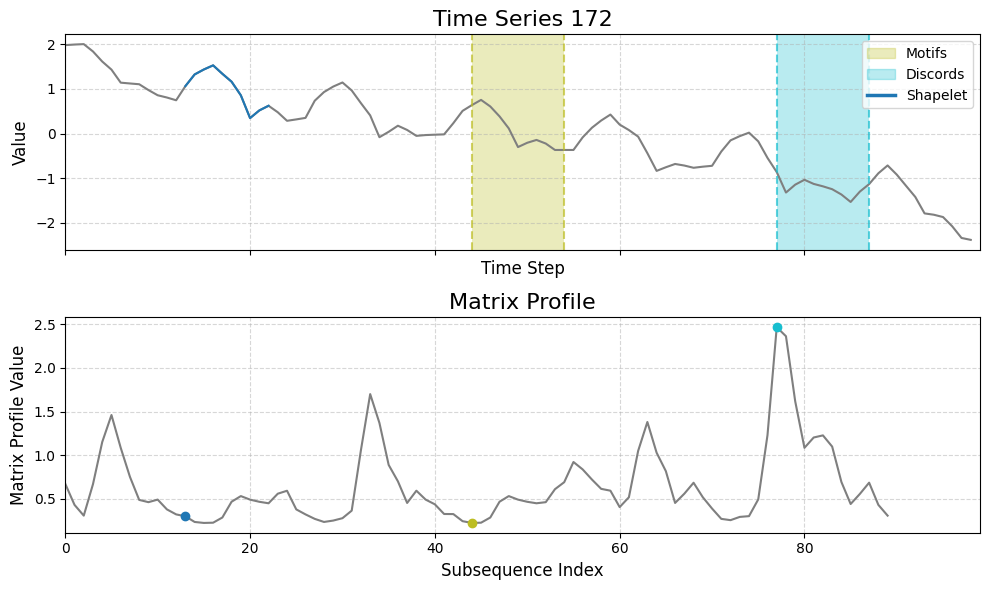

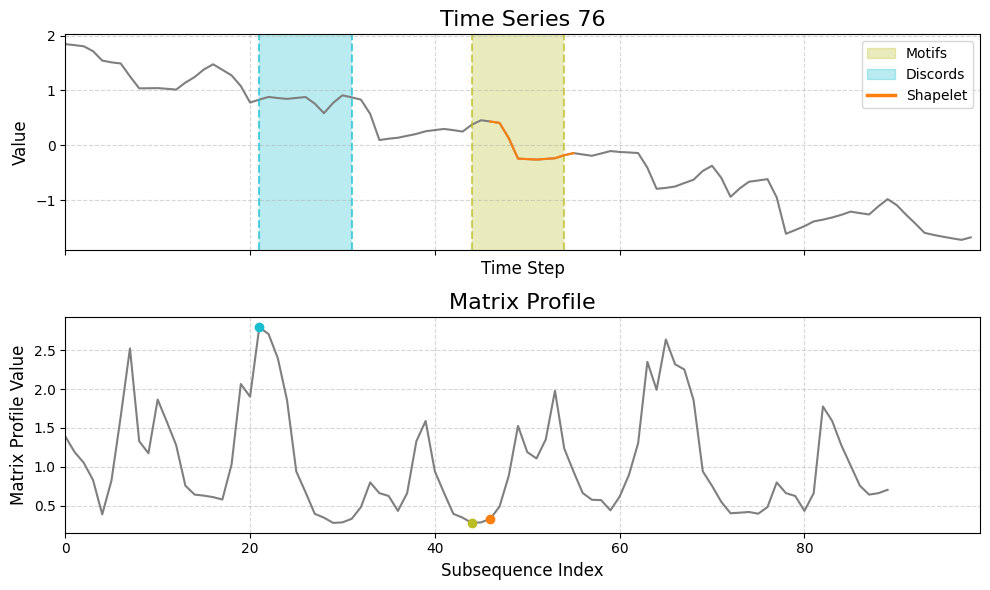

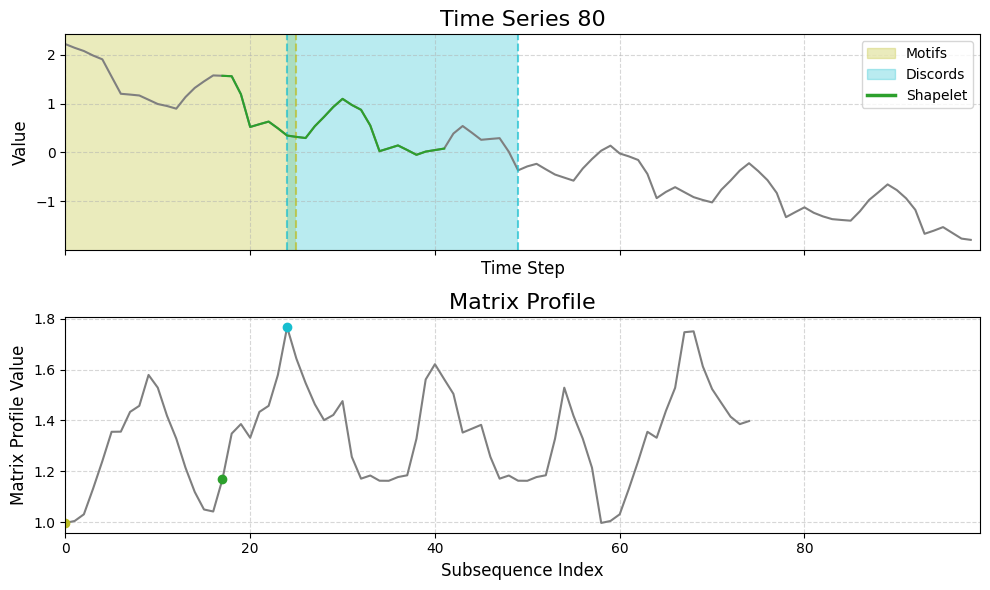

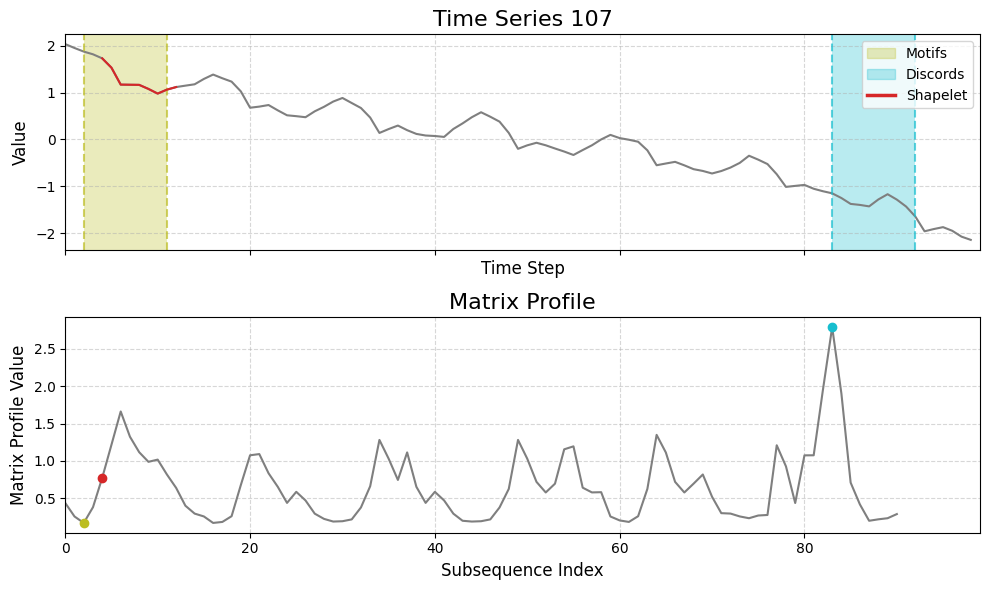

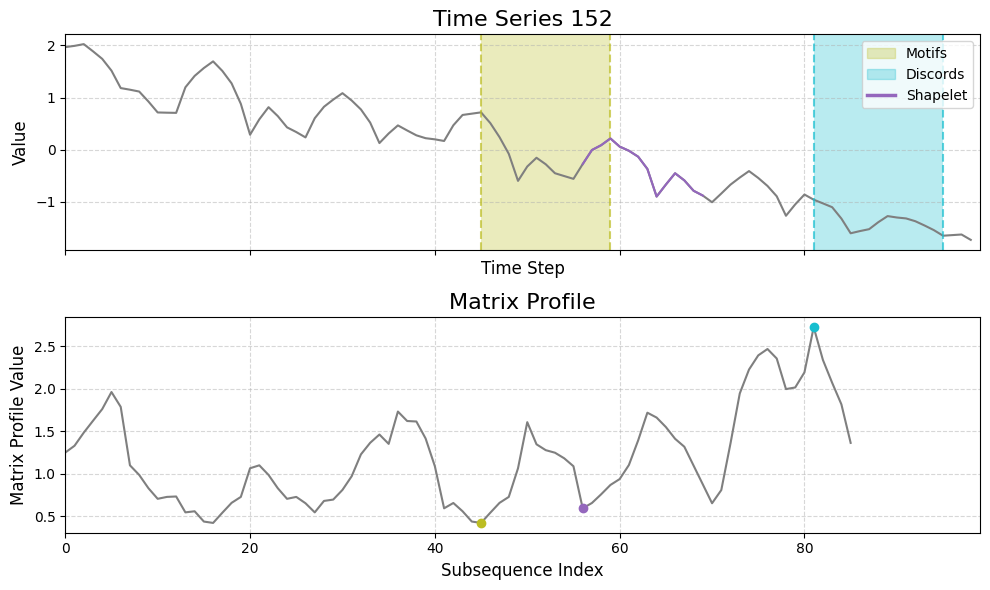

In [48]:
for rank, index in enumerate(top_indices[:5]):
    # Compute motifs and discords for the length of each shapelet
    length = len(all_shapelets[index][6])
    
    
    plot_matrix_profile(
        X_train_scaled.reshape(907, -1)[index],
        st.stump(X_train_scaled.reshape(907, -1)[index], length)[:, 0],
        length, index, 1, rank=rank
    )

In [49]:
import numpy as np
import saxpy.paa
import saxpy.sax
from saxpy.alphabet import cuts_for_asize

sax_map = {
    7  : (3, 3),
    14 : (4, 4),
    21 : (5, 4),
    28 : (4, 3)
}

def apply_sax(n, m):
    motifs_discords = []
    for time_series in X_scaled:
        # Compute the Matrix Profile for the current time series.
        mp = st.stump(time_series, m)[:, 0]
        
        # Find the top n motifs (lowest values in the matrix profile)
        motif_indices = np.argsort(mp)[:n]
        motifs = [idx for idx in motif_indices]
        
        # Find the top 3 discords (highest values in the matrix profile)
        discord_indices = np.argsort(mp)[-n:]
        discords = [idx for idx in discord_indices]
        
        motifs_discords.append({
            'motifs': motifs,
            'discords': discords
        })
        
    
    # Extract only the top motifs from each time series
    motifs = [idx for md in motifs_discords for idx in md['motifs']]

    seg_size = next((sax_map[k] for k in sorted(sax_map.keys()) if k >= m), "Out of range")
    cuts = cuts_for_asize(seg_size[1])

    sax_motifs = []
    for idx, start_idx in enumerate(motifs):
        # Replace motif_arr
        motif_arr = X_scaled[idx//n][start_idx:start_idx + m]
        
        motif_arr = np.array(motif_arr, dtype=float)

        paa_motif = saxpy.paa.paa(motif_arr, seg_size[0])

        sax_word = saxpy.sax.ts_to_string(paa_motif, cuts)
        sax_motifs.append(sax_word)

    print("SAX representations of top motifs:", sax_motifs)
    return sax_motifs, motifs, motifs_discords
    
m = 28
sax_motifs, motifs, motifs_discords = apply_sax(n=3, m=m)

SAX representations of top motifs: ['cbca', 'bbba', 'cbca', 'cbbb', 'bbaa', 'cbbb', 'cbba', 'aaaa', 'cbba', 'bbbb', 'bcbc', 'acac', 'cbba', 'aaaa', 'aaaa', 'cccb', 'aaaa', 'cccb', 'baaa', 'cccb', 'cccb', 'cbbb', 'aaaa', 'aaaa', 'baaa', 'ccbb', 'cbbb', 'cbcb', 'aaaa', 'bbba', 'cccb', 'cbbb', 'cccb', 'baba', 'cbbb', 'baba', 'cbbb', 'cccb', 'cbbb', 'abac', 'aaab', 'abac', 'bbaa', 'cbbb', 'cbbb', 'baaa', 'bbba', 'baaa', 'cbcb', 'baaa', 'cbcb', 'abbb', 'bccc', 'acac', 'abbc', 'aaaa', 'aabb', 'cbcb', 'cbbb', 'cbcb', 'cccb', 'baaa', 'baaa', 'baba', 'bbba', 'baba', 'baaa', 'cbbb', 'baaa', 'cbbb', 'bbbb', 'bbbb', 'bbab', 'bcbc', 'baba', 'cccb', 'cbbb', 'ccbb', 'aaaa', 'aaaa', 'aaaa', 'cccb', 'baaa', 'cbcb', 'cbcb', 'cbca', 'cbcb', 'aaaa', 'baaa', 'aaaa', 'baba', 'bbba', 'baba', 'cbba', 'baaa', 'bbba', 'baba', 'cbcb', 'cbcb', 'cbcb', 'baba', 'cbcb', 'bbba', 'cbbb', 'bbba', 'baba', 'baba', 'baba', 'baba', 'cbbb', 'cbbb', 'aaaa', 'bbba', 'aaaa', 'caba', 'cbca', 'baba', 'ccbb', 'bbaa', 'baaa', 'ccc

In [50]:
# Count occurrences, show top 10 most common
from collections import Counter
motif_counts = Counter(sax_motifs)

print("Top 10 most common motifs:")
for motif, count in motif_counts.most_common(10):
    print(f"Motif: {motif}, Count: {count}")

Top 10 most common motifs:
Motif: cbbb, Count: 467
Motif: aaaa, Count: 449
Motif: baaa, Count: 444
Motif: cccb, Count: 390
Motif: cbcb, Count: 336
Motif: bbba, Count: 284
Motif: baba, Count: 276
Motif: cbba, Count: 179
Motif: bbbb, Count: 99
Motif: ccbb, Count: 76


In [51]:
len(sax_motifs), len(motifs), len(motifs_discords)

(3402, 3402, 1134)

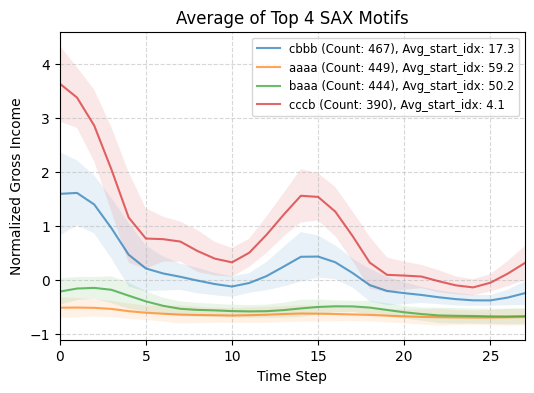

In [52]:
# Plot avg of top motifs by sax, with variance shaded
import matplotlib.pyplot as plt

top_motifs = motif_counts.most_common(4)  # Get top 9 motifs
plt.figure(figsize=(6, 4))
for motif, count in top_motifs:
    # Find all occurrences of this motif in the original motifs list
    occurrences = [
        X_scaled[i//3][motifs[i]:motifs[i]+m]
        for i, sax in enumerate(sax_motifs) if sax == motif
    ]
    
    occ_idcs = [
        motifs[i]
        for i, sax in enumerate(sax_motifs) if sax == motif
    ]
    
    # label = f'{motif} (Count: {count}), Avg_start_idx: {np.mean(occ_idcs):.1f},  Starting_Idx_σ: {np.std(occ_idcs):.2f}'
    label = f'{motif} (Count: {count}), Avg_start_idx: {np.mean(occ_idcs):.1f}'
    
    avg_motif = np.mean(occurrences, axis=0)
    plt.plot(avg_motif, label=label, alpha=0.7)
    # Shade variance
    std_motif = np.std(occurrences, axis=0)
    plt.fill_between(range(len(avg_motif)), avg_motif - std_motif, avg_motif + std_motif, alpha=0.1)
        
plt.title('Average of Top 4 SAX Motifs')
plt.xlabel('Time Step')
plt.ylabel('Normalized Gross Income')
plt.legend(fontsize='small')
plt.xlim(0, m - 1)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

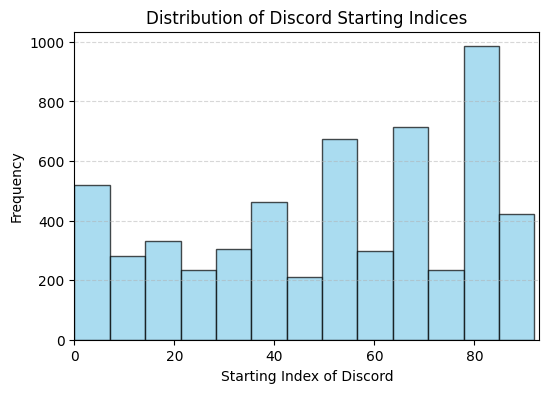

In [53]:
# Compute the indices of the top 3 discords for all time series
indices = []

for ts in X_scaled:
    profile_matr = st.stump(ts, 7)[:, 0]
    indices = indices + [np.argsort(profile_matr)[-5:].tolist()]

n_last2 = 0
# % of discords in the last 14 time slots
for idcs in indices:
    for idx in idcs:
        if idx >= 99 - 28:
            n_last2 += 1
            
# Plot the distribution of discord starting indices
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
all_indices = [idx for sublist in indices for idx in sublist]
plt.hist(all_indices, bins=13, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Discord Starting Indices')
plt.xlabel('Starting Index of Discord')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xlim(0, 99 - 6)
plt.show()

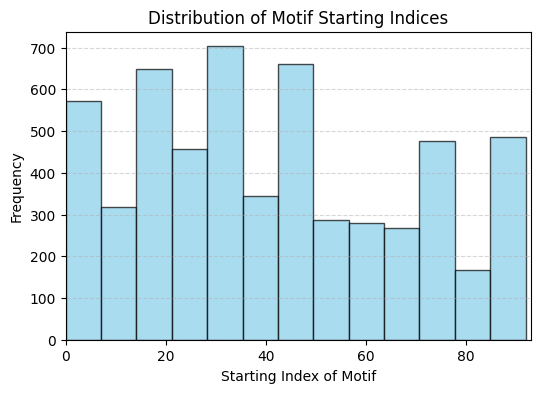

In [54]:
# Compute the indices of the top 3 motifs for all time series
motifs_indices = []

for ts in X_scaled:
    profile_matr = st.stump(ts, 7)[:, 0]
    motifs_indices = motifs_indices + [np.argsort(profile_matr)[:5].tolist()]

     
# Plot the distribution of discord starting indices
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
all_motifs_indices = [idx for sublist in motifs_indices for idx in sublist]
plt.hist(all_motifs_indices, bins=13, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Motif Starting Indices')
plt.xlabel('Starting Index of Motif')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xlim(0, 99 - 6)
plt.show()

SAX representations of top motifs: ['ddcd', 'cbaa', 'ddcd', 'ccaa', 'caaa', 'dbaa', 'dccc', 'dbaa', 'cbbb', 'dcaa', 'dcbb', 'ddcc', 'dccc', 'cbbb', 'ddcc', 'bbbd', 'bbbd', 'bbbc', 'bbbc', 'bbcd', 'bbbb', 'dbbb', 'cbbb', 'bbbb', 'cbbb', 'bbaa', 'ccbb', 'bbaa', 'bbbb', 'bbbb', 'aaaa', 'cbbb', 'aaaa', 'cbbb', 'baaa', 'bbbb', 'bbbb', 'cbbb', 'dcbb', 'bbbb', 'bbbb', 'ddcc', 'ddcc', 'bbbb', 'bbbb', 'dccb', 'bbbb', 'ddbb', 'bbbb', 'ddcc', 'bbaa', 'bbaa', 'bbaa', 'baaa', 'baaa', 'bbbb', 'dcbb', 'cbbb', 'bbbb', 'bbbb', 'dddc', 'cbbb', 'dddc', 'cbbb', 'dccb', 'cbbb', 'dccc', 'aabc', 'bbdd', 'aabc', 'dccb', 'cbbb', 'ddcc', 'ddcc', 'ddcc', 'bbbb', 'bbbb', 'dddd', 'bbbb', 'bbbb', 'ddbb', 'cbbb', 'bbbc', 'bbbd', 'bbcd', 'aabd', 'aaab', 'aaaa', 'dcbb', 'dbbb', 'dbbb', 'dccc', 'aaaa', 'baaa', 'aaaa', 'aabb', 'aabb', 'aabb', 'aabb', 'abbb', 'dcbb', 'bbaa', 'baaa', 'bbba', 'abbb', 'bbbb', 'cbbb', 'ddcc', 'dcbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'dcbb', 'cbbb', 'bcbb', 'dcc

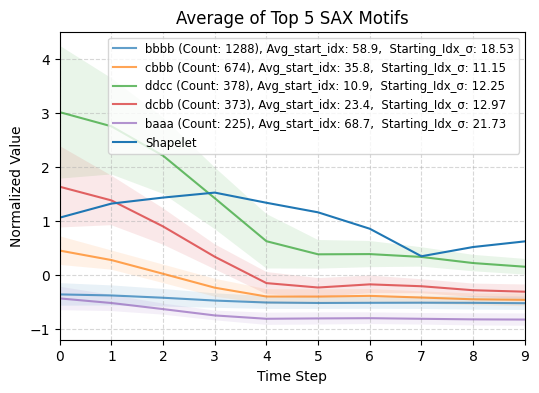

SAX representations of top motifs: ['ddcd', 'cbaa', 'ddcd', 'ccaa', 'caaa', 'dbaa', 'dccc', 'dbaa', 'cbbb', 'dcaa', 'dcbb', 'ddcc', 'dccc', 'cbbb', 'ddcc', 'bbbd', 'bbbd', 'bbbc', 'bbbc', 'bbcd', 'bbbb', 'dbbb', 'cbbb', 'bbbb', 'cbbb', 'bbaa', 'ccbb', 'bbaa', 'bbbb', 'bbbb', 'aaaa', 'cbbb', 'aaaa', 'cbbb', 'baaa', 'bbbb', 'bbbb', 'cbbb', 'dcbb', 'bbbb', 'bbbb', 'ddcc', 'ddcc', 'bbbb', 'bbbb', 'dccb', 'bbbb', 'ddbb', 'bbbb', 'ddcc', 'bbaa', 'bbaa', 'bbaa', 'baaa', 'baaa', 'bbbb', 'dcbb', 'cbbb', 'bbbb', 'bbbb', 'dddc', 'cbbb', 'dddc', 'cbbb', 'dccb', 'cbbb', 'dccc', 'aabc', 'bbdd', 'aabc', 'dccb', 'cbbb', 'ddcc', 'ddcc', 'ddcc', 'bbbb', 'bbbb', 'dddd', 'bbbb', 'bbbb', 'ddbb', 'cbbb', 'bbbc', 'bbbd', 'bbcd', 'aabd', 'aaab', 'aaaa', 'dcbb', 'dbbb', 'dbbb', 'dccc', 'aaaa', 'baaa', 'aaaa', 'aabb', 'aabb', 'aabb', 'aabb', 'abbb', 'dcbb', 'bbaa', 'baaa', 'bbba', 'abbb', 'bbbb', 'cbbb', 'ddcc', 'dcbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'dcbb', 'cbbb', 'bcbb', 'dcc

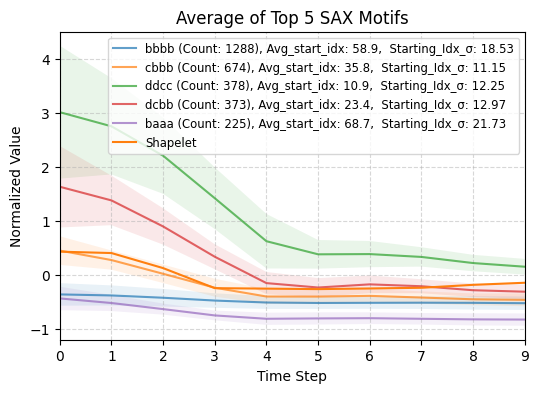

SAX representations of top motifs: ['cbca', 'baaa', 'cccb', 'baaa', 'cbca', 'cbbb', 'bbaa', 'cbbb', 'bbaa', 'cbbb', 'cbba', 'aaaa', 'aaaa', 'bbba', 'aaaa', 'cbbc', 'bbbb', 'cbbc', 'bbbb', 'bbac', 'aaaa', 'cbba', 'aaaa', 'bbba', 'cbba', 'cccb', 'aaaa', 'cccb', 'cbbb', 'cccb', 'cccb', 'baaa', 'aaaa', 'cccb', 'cbcb', 'bbaa', 'bcbb', 'aaaa', 'cbbb', 'bbab', 'baaa', 'cbcb', 'baaa', 'ccbb', 'baaa', 'cbcb', 'baba', 'cbcb', 'aaaa', 'baba', 'cccb', 'cbcb', 'cbcb', 'cbcb', 'cccb', 'bbab', 'ccbb', 'cbbb', 'baba', 'baba', 'cccb', 'cbbb', 'cccb', 'cbbb', 'bbbb', 'aaab', 'abac', 'bbbc', 'aaab', 'abac', 'bbba', 'cbbb', 'bbba', 'cbbb', 'cbbb', 'baaa', 'bbba', 'baaa', 'bbba', 'aaaa', 'baba', 'cbcb', 'baba', 'cbcb', 'cbcb', 'aaba', 'aaca', 'aaaa', 'bacb', 'aaba', 'abac', 'aaaa', 'abac', 'aaaa', 'abbc', 'cbcb', 'cbbb', 'cbcb', 'cbcb', 'cbcb', 'cbbb', 'baaa', 'baaa', 'cbbb', 'cbbb', 'bbab', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'cbbb', 'cbcb', 'cbcb', 'cbbb', 'cbbb', 'cbcb', 'bbbb', 'bbbb', 'baba', 'bbbb', 'bba

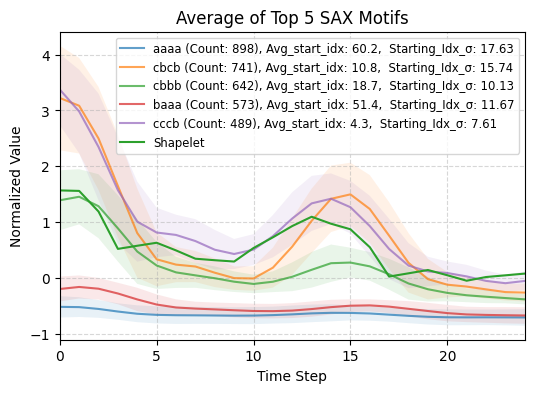

SAX representations of top motifs: ['ddcd', 'cbaa', 'ddcd', 'caaa', 'dddc', 'ccbb', 'baaa', 'bbaa', 'dddc', 'daaa', 'ddcc', 'dcbb', 'ccbb', 'ddcc', 'dccc', 'bbbd', 'bbbd', 'bbbd', 'bbbc', 'bbbc', 'bbbb', 'dcbb', 'bbbb', 'cbbb', 'cbbb', 'bbbb', 'bbba', 'bbbc', 'bbbb', 'bbbb', 'cbbb', 'aaaa', 'bbaa', 'ddbb', 'cbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'ddcc', 'ddcc', 'bbbb', 'bbbb', 'ddcc', 'bbbb', 'bbbb', 'dccb', 'bbbb', 'baaa', 'bbaa', 'bbaa', 'bbaa', 'baaa', 'bbbb', 'bbbb', 'bbbb', 'bbbc', 'ddcc', 'cbbb', 'dddc', 'dddc', 'cbbb', 'ddcc', 'cbbb', 'dccc', 'aabc', 'bbdd', 'baaa', 'cbbb', 'dccb', 'ddcc', 'dddc', 'ddcc', 'bbbb', 'dddc', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'dbbb', 'bbbc', 'bbcd', 'bbcd', 'aabd', 'aaab', 'bbbd', 'aaaa', 'aabd', 'ddcc', 'dcbb', 'aaaa', 'baaa', 'baaa', 'aabb', 'aabb', 'aabb', 'aabb', 'abbb', 'dcbb', 'bbaa', 'baaa', 'bbba', 'bbab', 'dddc', 'dcbb', 'bbbb', 'cbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'dccb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bccb', 'dcc

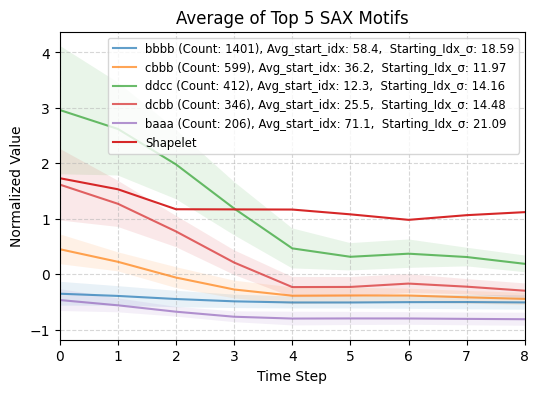

SAX representations of top motifs: ['ddcc', 'ccbb', 'dbbb', 'cbaa', 'bbaa', 'dccc', 'daaa', 'cbbb', 'dccc', 'daaa', 'ddcc', 'dcbb', 'ddcc', 'cbbb', 'bbba', 'bcbb', 'bdcb', 'bbcb', 'bbdb', 'bcbb', 'bbbb', 'ccbb', 'bbbb', 'dbbc', 'bbba', 'bbba', 'bcbb', 'bccb', 'abba', 'bbbb', 'cbbb', 'dcbb', 'baaa', 'cbbb', 'ccbb', 'bbbb', 'ccbb', 'bbbb', 'bcbb', 'bbbb', 'bbbb', 'dccd', 'bbbb', 'ddcd', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'bbbb', 'dccd', 'cbbb', 'dcbc', 'cbbb', 'dcbc', 'bbbb', 'cbbb', 'dcbc', 'bbbb', 'dbbc', 'cbbb', 'ccbb', 'ddcb', 'ddcd', 'dcbc', 'cbbb', 'babc', 'bbcd', 'aabc', 'bbdd', 'baac', 'cbbb', 'ddcb', 'ddcd', 'bbbb', 'bbbb', 'dddd', 'bbbb', 'bbbb', 'cbbb', 'bbbb', 'cbdd', 'bbcd', 'bbbb', 'ddbb', 'dcbc', 'aaab', 'baad', 'dcbb', 'dcbb', 'aaab', 'bbcd', 'aaab', 'bbdd', 'aaab', 'bbbd', 'aabb', 'aaba', 'aabb', 'aaba', 'abba', 'ddbb', 'bbaa', 'aabb', 'bbcc', 'dcbb', 'bcbb', 'bbbb', 'bcbb', 'bbbb', 'cbbb', 'bbbb', 'bbbb', 'bbbb', 'ddbb', 'cdcb', 'ccbb', 'bcbb', 'cbbb', 'ccbb', 'cdcb', 'ddc

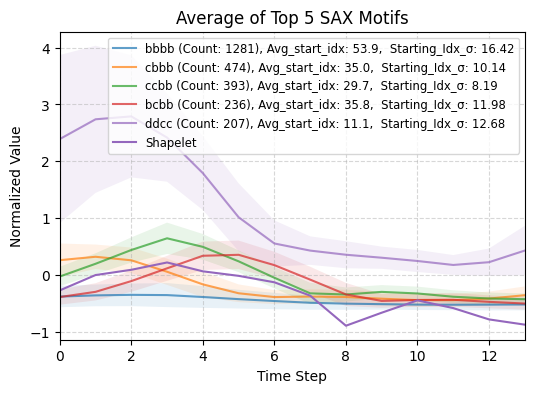

In [55]:
# For the top 3 shapelets, compare them with the n most important motifs of the same length
for rank, index in enumerate(top_indices[:5]):
    length = len(all_shapelets[index][6])
    
    sax_motifs, motifs, motifs_discords = apply_sax(n=5, m=length)
    
    motif_counts = Counter(sax_motifs)
    top_motifs = motif_counts.most_common(5)
    plt.figure(figsize=(6, 4))
    for motif, count in top_motifs:
        # Find all occurrences of this motif in the original motifs list
        occurrences = [
            X_scaled[i//5][motifs[i]:motifs[i]+length]
            for i, sax in enumerate(sax_motifs) if sax == motif
        ]
        
        occ_idcs = [
            motifs[i]
            for i, sax in enumerate(sax_motifs) if sax == motif
        ]
        
        label = f'{motif} (Count: {count}), Avg_start_idx: {np.mean(occ_idcs):.1f},  Starting_Idx_σ: {np.std(occ_idcs):.2f}'
        
        avg_motif = np.mean(occurrences, axis=0)
        
        plt.plot(avg_motif, label=label, alpha=0.7, )
        # Shade variance
        std_motif = np.std(occurrences, axis=0)
        plt.fill_between(range(length), avg_motif - std_motif, avg_motif + std_motif, alpha=0.1, )
    
    # Plot shapelet
    shapelet_array = all_shapelets[index][6]
    start_pos = all_shapelets[index][2]
    end_pos = start_pos + len(shapelet_array)
    indices = np.arange(start_pos, end_pos)
    
    plt.plot(
        np.arange(0, length),
        X_train_scaled.reshape(907, -1)[index][start_pos:end_pos],
        color=colors[rank],
        label='Shapelet',
    )
    
            
    plt.title('Average of Top 5 SAX Motifs')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend(fontsize='small')
    plt.xlim(0, length-1)
    plt.grid(alpha=0.5, linestyle='--')
    plt.show()

In [56]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import make_pipeline
# from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
# from sktime.datatypes._panel._convert import from_2d_array_to_nested
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# # --- Caricamento dataset ---
# # df = pd.read_csv("/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/imdb_ts.csv")

# # get parent dir
# parent_dir = os.path.dirname(os.getcwd())

# # load the dataset
# df = pd.read_csv(os.path.join(
#     parent_dir, 'dm2_dataset_2425_imdb',
#     'imdb_ts.csv'))

# # Merge classi poco rappresentate
# df["rating_category"] = df["rating_category"].replace({"Medium Low": "Low"})

# # Feature e target
# X_ts = df.iloc[:, 1:100].values
# y = df["rating_category"].values

# # Encoding target
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # --- Split dati ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X_ts, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
# )

# # --- Log-transform + Normalizzazione ---
# X_train_log = np.log1p(X_train)
# X_test_log = np.log1p(X_test)

# scaler_ts = TimeSeriesScalerMeanVariance()
# X_train_scaled = scaler_ts.fit_transform(X_train_log)
# X_test_scaled = scaler_ts.transform(X_test_log)

# # Conversione in formato nested per sktime
# X_train_nested = from_2d_array_to_nested(X_train_scaled.squeeze())
# X_test_nested = from_2d_array_to_nested(X_test_scaled.squeeze())

# # ==========================
# # Shapelet Transform + RandomizedSearchCV su RandomForest con class_weight='balanced'
# # ==========================
# shapelet_transform = RandomShapeletTransform(
#     max_shapelets=200,
#     min_shapelet_length=3,
#     max_shapelet_length=30,
#     random_state=42
# )

# rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# shapelet_pipeline = make_pipeline(shapelet_transform, rf_clf)

# # Parametri da ottimizzare per la Random Forest all'interno della pipeline
# param_dist = {
#     "randomforestclassifier__n_estimators": [100, 200, 300],
#     "randomforestclassifier__max_depth": [None, 10, 20, 30],
#     "randomforestclassifier__min_samples_split": [2, 5, 10],
#     "randomforestclassifier__min_samples_leaf": [1, 2, 4],
# }

# random_search = RandomizedSearchCV(
#     shapelet_pipeline,
#     param_distributions=param_dist,
#     n_iter=10,
#     cv=3,
#     scoring="accuracy",
#     n_jobs=-1,
#     random_state=42
# )

# # Fit della RandomizedSearch
# random_search.fit(X_train_nested, y_train)

# print("=== Shapelet Transform + RF (log-transformed, class_weight='balanced') RandomizedSearchCV ===")
# print("Best params:", random_search.best_params_)
# print("Best CV accuracy:", random_search.best_score_)

In [57]:
# import seaborn as sns
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import numpy as np

# # Desired order
# labels = ['Low', 'Medium', 'Medium High', 'High']

# # Map your label encoder classes to numeric values according to the desired order
# label_order_indices = [np.where(le.classes_ == lbl)[0][0] for lbl in labels]

# # Predictions
# y_pred = random_search.predict(X_test_nested)

# # Classification report with custom label order
# print(classification_report(
#     y_test, y_pred, labels=label_order_indices, target_names=labels
# ))

# # Confusion matrix with the same label order
# cm = confusion_matrix(y_test, y_pred, labels=label_order_indices)

# # Plot
# plt.figure(figsize=(5, 5))
# sns.heatmap(
#     cm, annot=True, fmt='d',
#     xticklabels=labels,
#     yticklabels=labels,
#     cmap='Reds', cbar=False
# )
# plt.xticks(rotation=0, ha='center')
# plt.yticks(rotation=0)
# plt.title("Confusion Matrix - Shapelet RF (log-transformed, class_weight='balanced')")
# plt.show()


In [58]:
# # Print most influential shapelets for each class
# st = random_search.best_estimator_.named_steps['randomshapelettransform']
# clf = random_search.best_estimator_.named_steps['randomforestclassifier']

# # try to get shapelets array and metadata (robust to different attribute names)
# shapelets = getattr(st, "shapelets_", None) or getattr(st, "_shapelets", None)
# info = getattr(st, "shapelet_info_", None) or getattr(st, "shapelets_info_", None) or getattr(st, "shapelets_infos_", None)

# # helper to print a single shapelet entry
# def _print_shapelet_entry(idx, shapelet_arr=None, start=None, length=None, quality=None):
#     print(f"  - shapelet_idx={idx} start={start} length={length} quality={quality}")
#     if shapelet_arr is not None:
#         # keep printing compactly
#         print("    values:", np.array2string(np.asarray(shapelet_arr), precision=3, separator=", ", max_line_width=120))

# if info is not None:
#     # normalize info to DataFrame for easier handling
#     info_df = info if isinstance(info, pd.DataFrame) else pd.DataFrame(info)
#     # detect useful columns
#     class_col = next((c for c in ['class_id', 'class', 'y', 'class_labels'] if c in info_df.columns), None)
#     id_col = next((c for c in ['shapelet_id', 'id', 'idx', 'index', 'shapelet_index'] if c in info_df.columns), None)
#     quality_col = next((c for c in ['quality', 'score', 'gini_gain'] if c in info_df.columns), None)
#     start_col = next((c for c in ['start', 'pos'] if c in info_df.columns), None)
#     length_col = next((c for c in ['length', 'len'] if c in info_df.columns), None)

#     for cid, cls in enumerate(le.classes_):
#         # filter by class if available, otherwise show top-general shapelets
#         rows = info_df[info_df[class_col] == cid] if class_col is not None else info_df
#         if rows.empty:
#             print(f"No shapelets found for class '{cls}'")
#             continue
#         # sort by quality if available
#         if quality_col is not None:
#             rows = rows.sort_values(by=quality_col, ascending=False)
#         print(f"Top shapelets for class '{cls}':")
#         for _, r in rows.head(5).iterrows():
#             sidx = int(r[id_col]) if id_col is not None and not pd.isna(r[id_col]) else None
#             sval = r.get('shapelet', None)
#             # prefer shapelet array from metadata, else from shapelets list using sidx
#             arr = sval if sval is not None else (shapelets[sidx] if (shapelets is not None and sidx is not None and sidx < len(shapelets)) else None)
#             _print_shapelet_entry(sidx, arr, r.get(start_col), r.get(length_col), r.get(quality_col))
#         print()
# else:
#     # fallback: no metadata available -> use RF global feature importances to rank shapelet features
#     importances = clf.feature_importances_
#     n_show = min(10, len(importances))
#     top_idx = np.argsort(importances)[::-1][:n_show]
#     print("No shapelet metadata available. Showing top shapelets by RandomForest global feature importance:")
#     for rank, fi in enumerate(top_idx, start=1):
#         print(f"{rank}. feature_idx={fi} importance={importances[fi]:.6f}")
#         if shapelets is not None and fi < len(shapelets):
#             _print_shapelet_entry(fi, shapelets[fi])
#         else:
#             print("   (shapelet values not available)")


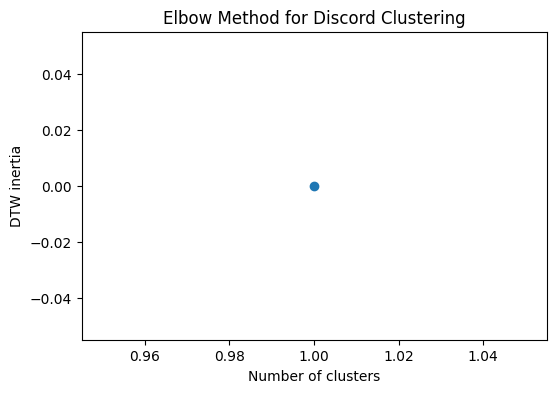

Cluster 0: 1 discords


In [ ]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import matplotlib.pyplot as plt

# -------------------------------
# 1. Extract discords
# -------------------------------
# Take the first discord from each time series as example


discords = [md['discords'][0] for md in motifs_discords]

# Convert to a 3D array (tslearn format: n_ts x sz x d)
# If univariate, d=1
discords_ts = to_time_series_dataset(discords)  # shape: (n_discords, m, 1)

# -------------------------------
# 2. Determine optimal number of clusters using the elbow method
# -------------------------------
# We'll use DTW KMeans
distortions = []
K_range = range(1, min(10, len(discords)+1))  # try up to 10 clusters or #discords

for k in K_range:
    km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42, verbose=0)
    km_dtw.fit(discords_ts)
    distortions.append(km_dtw.inertia_)  # sum of DTW distances to cluster centroids

# Plot the elbow curve
plt.figure(figsize=(6,4))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('DTW inertia')
plt.title('Elbow Method for Discord Clustering')
plt.show()

# -------------------------------
# 3. Fit final clustering
# -------------------------------
# Choose optimal k based on the elbow, e.g., k=3
optimal_k = 3
km_dtw = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", random_state=42)
labels = km_dtw.fit_predict(discords_ts)

# -------------------------------
# 4. Inspect clusters
# -------------------------------
from collections import defaultdict

clusters = defaultdict(list)
for label, discord in zip(labels, discords):
    clusters[label].append(discord)

for label, members in clusters.items():
    print(f"Cluster {label}: {len(members)} discords")
